In [1]:
from qick import *
from qick.rfboard import RFQickSoc216V1

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = RFQickSoc216V1('./qick_rf216_v2.bit', clk_output=None)
soccfg = soc

print(soccfg)

resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Software version: 0.2.228
	Firmware timestamp: Wed Jan 31 08:18:41 2024

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	16 signal generator channels:
	0:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_int4_v1 - envelope memory 4096 samples (9.524 us)
		fs=6881.280 M

### general notes
* In this firmware, generator numbers map directly to front-panel DAC port numbers. (This is not a fundamental rule, and we will eventually put the front-panel port numbers next to the JHC port numbers in the soccfg printout.)
* In this firmware, readouts 4-7 map to front-panel ADC ports 0-3; readouts 0-3 are multiplexed onto front-panel ADC port 4.
* In this firmware, the digital output pins from the tProc map to the first four User I/O SMA ports.

  0%|          | 0/1 [00:00<?, ?it/s]

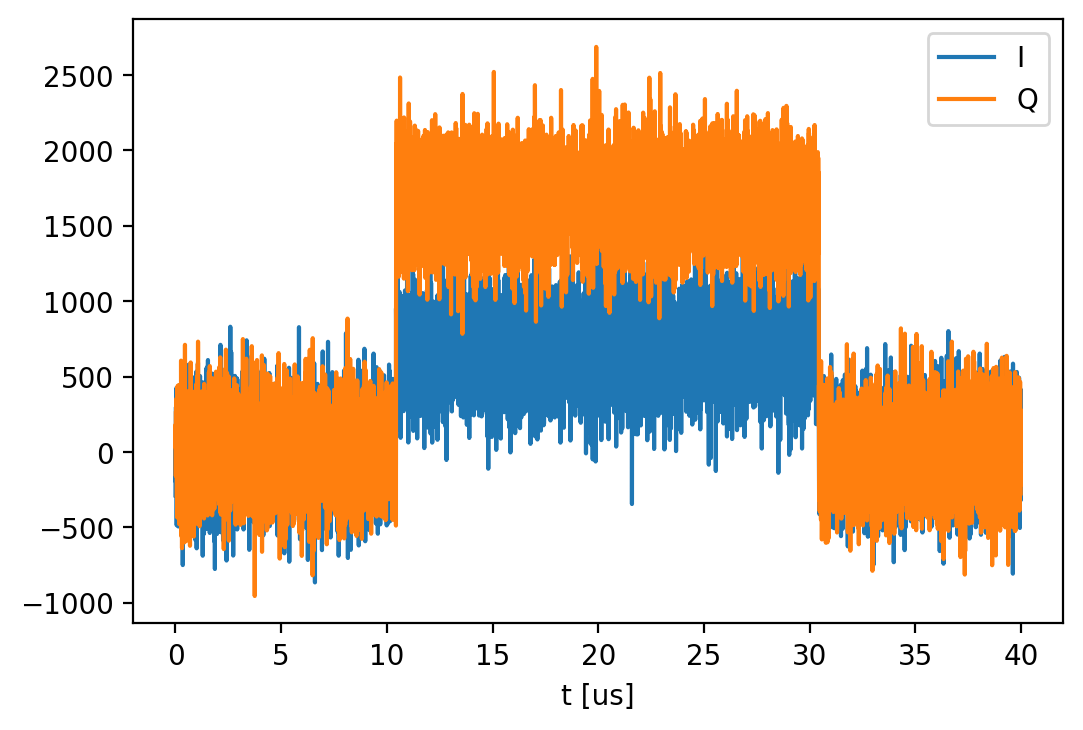

In [226]:
##########################################
### One generator/readout and raw-data ###
##########################################
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=self.cfg['gen_nqz'])
        
        # DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'][0])
        self.set_pulse_registers(ch     = self.cfg['gen_ch'], 
                                 style  = 'const', 
                                 freq   = freq,
                                 phase  = 0, 
                                 gain   = self.cfg['pulse_gain'], 
                                 length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'],
                             gen_ch  = self.cfg['gen_ch'])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0],
                     t               = self.us2cycles(self.cfg['pulse_start']),
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [5],
        "ro_length"   : 40,
        "ro_freq"     : 4000,
        "ro_offset"   : 0,
        
        "gen_ch"      : 14,        
        "gen_nqz"     : 2,
        "pulse_length": 20,
        "pulse_start" : 10,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 4000,
        
        "reps"        : 1,
        "period"      : 20
       }

########################
### RF Board Setting ###
########################

#######
# DAC #
#######
freq = config['pulse_freq']

# Set Filter.
soc.rfb_set_gen_filter(config['gen_ch'], fc=fc, ftype='bandpass')
#soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 15, 20)

#######
# ADC #
#######
# Set Filter.
soc.rfb_set_ro_filter(config['ro_ch'][0], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'][0], 20)

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc)

# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


### little note on the generator outputs
This firmware uses the "tmux" which multiplexes multiple generators onto each tProc output. Generally this works transparently, but be aware that if you try to play simultaneous pulses on generators that share a tmux channel, the pulses will get offset by a tProc clock cycle (or something like that).

In [8]:
soccfg['gens']

[{'type': 'axis_sg_int4_v1',
  'fullpath': 'axis_sg_int4_v1_0',
  'tmux_ch': 0,
  'tproc_ch': 0,
  'dac': '00',
  'fs': 4915.2,
  'fs_mult': 40,
  'fs_div': 2,
  'interpolation': 4,
  'f_fabric': 307.2,
  'f_dds': 1228.8,
  'fdds_div': 8,
  'maxlen': 4096,
  'b_dds': 16,
  'switch_ch': 0,
  'samps_per_clk': 1,
  'maxv': 32766,
  'maxv_scale': 0.9},
 {'type': 'axis_sg_int4_v1',
  'fullpath': 'axis_sg_int4_v1_1',
  'tmux_ch': 1,
  'tproc_ch': 0,
  'dac': '01',
  'fs': 4915.2,
  'fs_mult': 40,
  'fs_div': 2,
  'interpolation': 4,
  'f_fabric': 307.2,
  'f_dds': 1228.8,
  'fdds_div': 8,
  'maxlen': 4096,
  'b_dds': 16,
  'switch_ch': 1,
  'samps_per_clk': 1,
  'maxv': 32766,
  'maxv_scale': 0.9},
 {'type': 'axis_sg_int4_v1',
  'fullpath': 'axis_sg_int4_v1_2',
  'tmux_ch': 2,
  'tproc_ch': 0,
  'dac': '02',
  'fs': 4915.2,
  'fs_mult': 40,
  'fs_div': 2,
  'interpolation': 4,
  'f_fabric': 307.2,
  'f_dds': 1228.8,
  'fdds_div': 8,
  'maxlen': 4096,
  'b_dds': 16,
  'switch_ch': 2,
  'samps

In [10]:
[(i,gen['tproc_ch']) for i,gen in enumerate(soccfg['gens'])]

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 2),
 (10, 3),
 (11, 3),
 (12, 4),
 (13, 4),
 (14, 5),
 (15, 6)]

In [14]:
soc.ip_dict.keys()

dict_keys(['axi_dma_avg', 'axi_dma_buf', 'axi_dma_gen', 'axi_dma_tproc', 'axis_avg_buffer_0', 'axis_avg_buffer_1', 'axis_avg_buffer_2', 'axis_avg_buffer_3', 'axis_avg_buffer_4', 'axis_avg_buffer_5', 'axis_avg_buffer_6', 'axis_avg_buffer_7', 'axis_pfb_readout_v2_0', 'axis_readout_v2_1', 'axis_readout_v2_2', 'attn_spi', 'axis_readout_v2_3', 'axis_readout_v2_4', 'axis_sg_int4_v1_1', 'axis_sg_int4_v1_2', 'axis_switch_avg', 'axis_switch_buf', 'axis_switch_gen', 'axis_sg_int4_v1_3', 'axis_sg_int4_v1_4', 'axis_sg_int4_v1_0', 'axis_signal_gen_v6_8', 'usp_rf_data_converter_0', 'axis_signal_gen_v6_9', 'bias_gpio', 'bias_spi', 'brd_sel_gpio', 'filter_spi', 'pmod_bits_gpio', 'pmod_led_gpio', 'axis_sg_mux4_v3_0', 'axis_sg_int4_v1_5', 'axis_sg_int4_v1_6', 'axis_sg_int4_v1_7', 'axis_signal_gen_v6_10', 'axis_signal_gen_v6_11', 'axis_signal_gen_v6_12', 'axis_signal_gen_v6_13', 'axis_signal_gen_v6_14', 'axis_tproc64x32_x8_0', 'zynq_ultra_ps_e_0'])

### playing with LEDs (and ribbon I/O connector)
The LEDs are wired to the PMOD0 connector on the ZCU216, the ribbon is wired to PMOD1. In this firmware these are connected to an AxiGPIO which is controlled by software (vs. in most QICK firmware, where the PMODs are connected to the tProc). So these are for slow control.

The LEDs are very dim (trying to drive the LEDs directly with PMOD outputs?).

There is also some weirdness with the AxiGPIO we're using for this.

The ribbon connector works identically (`soc.pmod_bits_gpio` instead of `soc.pmod_led_gpio`), except that the pin mapping seems to be screwed up somewhere, such that even and odd pins are swapped: PMOD1_0=ribbon signal 1, PMOD 1_1=ribbon signal 0, etc. The ribbon pins should be input-capable, but I haven't checked.

In [16]:
help(soc.pmod_led_gpio)

Help on AxiGPIO in module pynq.lib.axigpio object:

class AxiGPIO(pynq.overlay.DefaultIP)
 |  AxiGPIO(description)
 |  
 |  Class for interacting with the AXI GPIO IP block.
 |  
 |  This class exposes the two banks of GPIO as the `channel1` and
 |  `channel2` attributes. Each channel can have the direction and
 |  the number of wires specified.
 |  
 |  The wires in the channel can be accessed from the channel using
 |  slice notation - all slices must have a stride of 1. Input wires
 |  can be `read` and output wires can be written to, toggled, or
 |  turned off or on. InOut channels combine the functionality of
 |  input and output channels. The tristate of the pin is determined
 |  by whether the pin was last read or written.
 |  
 |  Method resolution order:
 |      AxiGPIO
 |      pynq.overlay.DefaultIP
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, idx)
 |  
 |  __init__(self, description)
 |      Initialize self.  See help(type(self)) for accu

In [219]:
# this works
while True:
    for ch in soc.pmod_led_gpio:
        ch.on()
    time.sleep(1)
    for ch in soc.pmod_led_gpio:
        ch.off()
    time.sleep(1)
    

KeyboardInterrupt: 

In [215]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].on()
            else:
                soc.pmod_led_gpio[j].off()
        time.sleep(0.2)

KeyboardInterrupt: 

In [214]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].write(1)
            else:
                soc.pmod_led_gpio[j].write(0)
        time.sleep(0.2)

KeyboardInterrupt: 

In [213]:
# this works
while True:
    for i in range(8):
        soc.pmod_led_gpio.channel1.write(val=1<<i, mask=0xFF)
        time.sleep(0.2)


KeyboardInterrupt: 

In [203]:
# this doesn't work, not sure why
while True:
    soc.pmod_led_gpio.channel1.write(0x0,0xFF)
    time.sleep(1)
    soc.pmod_led_gpio.channel1.write(0xFF,0xFF)
    time.sleep(1)
    

KeyboardInterrupt: 

In [175]:
help(soc.pmod_led_gpio.channel1.write)

Help on method write in module pynq.lib.axigpio:

write(val, mask) method of pynq.lib.axigpio.Channel instance
    Set the state of the output pins

